In [10]:
import pandas as pd
import sqlite3 as sql

db = sql.connect('github.db')
c = db.cursor()

In [69]:
# This query finds all the issue ids where there was an opening and closing action for the 
# issue itself. It then inserts the results into a temporary table QUERY1 for later use.
# NOTE: 
# 1. It's likely that some issues will be reopened and then closed again
# 2. For some reason not all issues will be in the DB, perhaps due to pre-processing error?

QUERY1 = '''
CREATE TEMP TABLE QUERY1 AS 
SELECT issue_id
  FROM (
           SELECT repo_id,
                  issue_id,
                  [action]
             FROM issues_events
            WHERE [action] = 'opened'
           UNION
           SELECT repo_id,
                  issue_id,
                  [action]
             FROM issues_events
            WHERE [action] = 'closed'
       )
       AS R1
 WHERE repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
 GROUP BY repo_id,
          issue_id
HAVING COUNT( * ) = 2;
'''
c.execute(QUERY1)

In [70]:
# This query uses the QUERY1 results to select the number of times that issue appeared MOD 2 = 0
# and inserts the results into a temporary table QUERY2 for later use. Since the only actions in 
# this table are 'opened', 'closed', and 'reopened'. MOD 2 = 0 means there was a pair of opening
# and closing actions that occured.

QUERY2 =  '''
CREATE TEMP TABLE QUERY2 AS
SELECT issue_id
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY1)
 GROUP BY repo_id,
          issue_id
HAVING COUNT( * ) % 2 = 0;
'''
c.execute(QUERY2)

In [71]:
# This query uses the QUERY2 results to select the date the issue was FIRST OPENED and
# inserts the results into a temporary table DT_OPENED for later use.

DT_OPENED = '''
CREATE TEMP TABLE DT_OPENED AS
SELECT repo_id,
       issue_id,
       issue_number,
       title AS opened_title,
       MIN(date_created) AS exact_date_opened
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY2)
 GROUP BY repo_id,
          issue_id,
          issue_number;
'''
c.execute(DT_OPENED)

In [73]:
# This query uses the QUERY2 results to select the date the issue was LAST CLOSED and
# inserts the results into a temporary table DT_CLOSED for later use.

DT_CLOSED = '''
CREATE TEMP TABLE DT_CLOSED AS
SELECT repo_id,
       issue_id,
       issue_number,
       title AS closed_title,
       MAX(date_created) AS exact_date_closed
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY2)
 GROUP BY repo_id,
          issue_id,
          issue_number;
'''
c.execute(DT_CLOSED)

In [74]:
issue_query = '''
SELECT o.*, 
       c.closed_title,
       c.exact_date_closed,
       ROUND(ABS(julianday(o.exact_date_opened) - julianday(c.exact_date_closed) ), 2) AS exact_date_diff
  FROM [temp].DT_OPENED AS o
       LEFT JOIN
       [temp].DT_CLOSED AS c ON (o.repo_id = c.repo_id AND 
                                 o.issue_id = c.issue_id) 
 ORDER BY o.repo_id,
          o.issue_number;
'''
issues = pd.read_sql(issue_query, db)

In [75]:
issues.head()

,repo_id,issue_id,issue_number,opened_title,exact_date_opened,closed_title,exact_date_closed,exact_date_diff
0,48933503,130229006,16,Toolbar title sometimes gets cut off with elli...,2016-02-01 01:57:44,Toolbar title sometimes gets cut off with elli...,2016-02-14 05:06:52,13.13
1,48933503,130229075,17,Homepage FAB sometimes doesn't have correct in...,2016-02-01 01:58:17,Window insets occasionally not applied,2016-02-10 17:19:23,9.64
2,48933503,130232230,18,about section,2016-02-01 02:11:08,Bottom inset sometimes isn't applied to the ab...,2016-02-01 05:08:55,0.12
3,48933503,130233551,19,Severe landscape issues,2016-02-01 02:18:07,Severe landscape issues,2016-02-01 04:58:27,0.11
4,48933503,130332865,20,"Tapping a wallpaper to load it full-size, resu...",2016-02-01 11:14:34,"Tapping a wallpaper to load it full-size, resu...",2016-02-01 18:25:32,0.30


In [90]:
tmp=[issues['opened_title']==issues['closed_title']]
acc=sum(tmp[0])/len(tmp[0])
1-acc

0.077759836831817752

In [16]:
# Now we can use the issues DataFrame to do parameterized queries to get 
# the number of forks occuring between the issue periods for each repo.

DFs = []
for idx, row in issues.iterrows():
    
    query = '''
    SELECT repo_id, issue_id, date_created, comment, user_id, user_login
      FROM issue_comment_events
     WHERE repo_id = :repo_id AND 
           issue_id = :issue_id AND
           date_created <= :dt_closed;
    '''
    result = pd.read_sql(query, db, params={'repo_id': row.repo_id,
                                            'issue_id': row.issue_id,
                                            'dt_closed': row.exact_date_closed})
    DFs.append(result)

comments = pd.concat(DFs, axis=0, ignore_index=True)

In [17]:
issues_comments = pd.merge(issues, comments, how='inner', on=['repo_id', 'issue_id'])

In [68]:
# Drop the temporary tables
c.executescript('''
DROP TABLE [temp].QUERY1; 
DROP TABLE [temp].QUERY2;
DROP TABLE [temp].DT_OPENED;
DROP TABLE [temp].DT_CLOSED;
''')
db.commit()

In [18]:
issues_comments.head()

,repo_id,issue_id,issue_number,exact_date_opened,exact_date_closed,exact_date_diff,date_created,comment,user_id,user_login
0,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-02 01:46:17,![screener_20160201 19-45-19](https://cloud.gi...,1820165.0,afollestad
1,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-08 19:29:20,@plusCubed have you ever seen this before?\r\n...,1820165.0,afollestad
2,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-09 00:59:14,There has also been problems with toolbar icon...,6379975.0,plusCubed
3,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-12 00:12:59,"I believe it's fixed, will re-open if that's n...",1820165.0,afollestad
4,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-12 11:59:42,I am experiencing this bug with 7f19698e3046b5...,9100169.0,crutchcorn


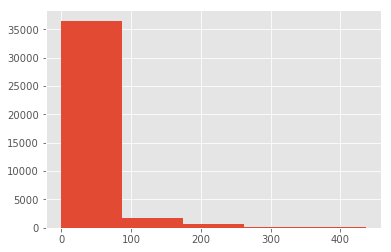

In [87]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

plt.hist(issues_comments['exact_date_diff'], bins=5, label='Date diff')
plt.show()

In [88]:
tmp=issues_comments.loc[issues_comments['exact_date_diff']<5]
tmp.shape[0]/issues_comments.shape[0]

0.5101274552374141

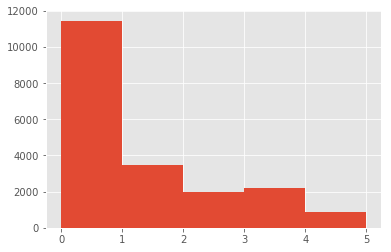

In [89]:
plt.hist(tmp['exact_date_diff'], bins=5, label='Date diff')
plt.show()

obviously, Group by date diff does not make any sense. Try group by action(open and close). It seems most of issues open and close at the same day.

In [24]:
import numpy as np
from nltk import corpus
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

def display_topics(model, feature_names):
    for i, topic in enumerate(model.components_):
        print("Topic %d:" % (i))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-11 - 1:-1]]))
        
def lemmatize(text, stop=0):
    """
    Tokenization, and Stemming
    Input: text(string need to be cleaned), 
    Output: a tokenized, and stemmed list of words 
    """
    #Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())
    if stop==1:
        stopped = [word for word in tokens if word not in stopwords.words('english')]
    else:
        stopped=tokens
    #Stemming
    stemmer = PorterStemmer().stem
    return [stemmer(w.lower()) for w in stopped]

#vectorizition
tfidf_vectorizer=TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True, norm=None)
texts=issues_comments['comment'].tolist()
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
0 1 tgz yarnpkg registri 2 resolv babel 3 6 version
Topic 1:
08 active_pokemon_id search_worker_0 168 retri tabl pokestop column 23 warn 13
Topic 2:
19116 19147 breventserv 03 10 15 d com android tencent 13
Topic 3:
7 framework __getitem__ python ctype self cellar __init__ python2 2 usr
Topic 4:
s0 u c768 c512 scontext tcontext tclass avc object_r comm ino
Topic 5:
03 02 1052 13 47 14157 0 48 android 4187 com
Topic 6:
6208 breventserv 29 03 15 d 44 45 com android ele
Topic 7:
9172 9204 breventserv 03 15 10 47 com d v 48
Topic 8:
3d 0a 20 3b 3a 3anth 2f 20li 0aul 20background 20color
Topic 9:
04 breventserv 03 androidruntim d java 17 e 19 01 16787


In [25]:
query="SELECT * FROM issue_comment_events where comment like '%yarnpkg%' group by repo_id"
tmp = pd.read_sql(query, db)
tmp.shape

(6, 11)

In [62]:
query="""SELECT action,
       title,
       description,
       MIN(date_created) AS exact_date_opened
FROM issues_events
GROUP BY repo_id,
        issue_id,
        issue_number;"""

#query = "SELECT action, title,description, FROM issues_events"
issue_comments_2 = pd.read_sql(query, db)
issue_comments_2=issue_comments_2.drop_duplicates(subset='title',keep='last')
issue_comments_2=issue_comments_2.dropna(axis=0)
issue_comments_2['comment']=issue_comments_2['title']+issue_comments_2['description']
issue_comments_opened=issue_comments_2.loc[issue_comments_2['action'] == 'opened']['title'].tolist()
issue_comments_closed=issue_comments_2.loc[issue_comments_2['action'] == 'closed']['title'].tolist()
issue_comments_opened_description=issue_comments_2.loc[issue_comments_2['action'] == 'opened']['description'].tolist()
issue_comments_closed_description=issue_comments_2.loc[issue_comments_2['action'] == 'closed']['description'].tolist()
issue_comments_reopened=issue_comments_2.loc[issue_comments_2['action'] == 'reopened']['title'].tolist()
issue_comments_reopened_description=issue_comments_2.loc[issue_comments_2['action'] == 'reopened']['description'].tolist()

In [66]:
issue_comments_2.loc[issue_comments_2['action'] == 'reopened']

,action,title,description,exact_date_opened,comment
12524,reopened,/,0.90.9.1\r\n\r\n- \r\n- 3-5\r\n- \r\nID com.ea...,2017-03-24 06:00:15,/0.90.9.1\r\n\r\n- \r\n- 3-5\r\n- \r\nID com.e...


In [54]:
texts=issue_comments_opened
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
0 1 2 9 3 4 version 7 5 downgrad 6
Topic 1:
t doesn don isn updat won input load aren instal zappa
Topic 2:
error build messag pars compil javascript object thi load modul undefin
Topic 3:
add support option link type suggest new enhanc custom command abil
Topic 4:
file mix js css path compil download sass version directori onli
Topic 5:
use valid instead thi data chang input node api s select
Topic 6:
notif app io android receiv background crash push foreground icon fcm
Topic 7:
request featur scan chang type locat pokemon pull multipl option set
Topic 8:
work doe map exampl valid properli doesn doesnt locat mix onli
Topic 9:
run npm fail instal dev build issu pipenv product window hot


It shows version downgrad is one of the top reason for issue opened action

In [55]:
texts=issue_comments_closed
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
0 2 3 1 sinc broken 10 window build 9 whi
Topic 1:
block mode class syntaxerror outsid declar strict scope const function npm
Topic 2:
add serial test entir delet backspac abil ctrl html line transform
Topic 3:
leaf data key text render forc offset chang work error push
Topic 4:
node use sass support express seper webpack environ current doe server
Topic 5:
request page sometim t set transpar fab bar isn nav inset
Topic 6:
transform creat new allow state don focu t snapshot save instanc
Topic 7:
mix ani way file laravel js parti transpil let tutori 5
Topic 8:
uninstal dev end compil process use watch automat poll run pipenv
Topic 9:
http locat post zeep wsdl despit updat a9lh fbi inject bug


Top issues
1. version problem, add new files, downgrade to fix
2. relative sources issue, such as operation system 
3. syntax error
4. 



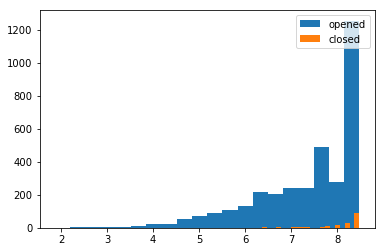

In [57]:
from matplotlib import pyplot as plt
def text_dictionary(texts):
    textd={}
    for text in texts:
        #t=corpus.reuters.raw(text)
        s =set(lemmatize(text))
        try:
            toks=toks|s
        except NameError:
            toks=s
        for tok in s:
            try:
                textd[tok].append(text)
            except KeyError:
                    textd[tok]=[text]
    tok_list=list(toks)
    return [textd,tok_list]

def idf_smooth(texts):
    textd=text_dictionary(texts)[0]
    numd={key:len(set(val)) for key,val in textd.items()}
    logN=np.log(len(issue_comments_2['title']))
    return {key:logN-np.log(1+val) for key,val in numd.items() if val>1}

idf_smooth_opened=idf_smooth(issue_comments_opened)
idf_smooth_closed=idf_smooth(issue_comments_closed)

plt.hist(list(idf_smooth_opened.values()), bins=20, label='opened')
plt.hist(list(idf_smooth_closed.values()), bins=20,label='closed')
plt.legend(loc='upper right')
plt.show()

From above plot, we can know that the opened titles are typically cover the same content as colsed title.

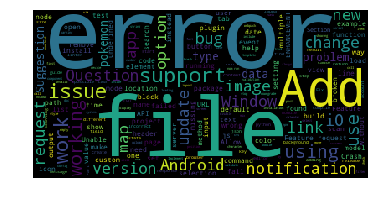

In [33]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(" ".join(issue_comments_opened))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

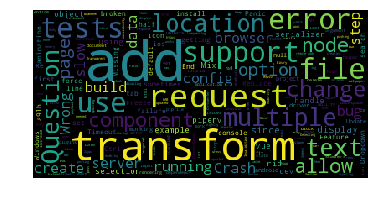

In [58]:
wordcloud = WordCloud().generate(" ".join(issue_comments_closed))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [52]:
issue_comments_closed[:200]

['Plaid-like animation for search (in icons/wallpapers)',
 'Replace PkRequestManager',
 'Select all/none option in the Requests page is sometimes invisible',
 "Transparent nav bar inset sometimes isn't set to the FAB in the Requests page",
 'Icon request "backend"',
 'Keep getting "File exists" error on Amazon Linux when creating ZIP',
 'Detecting if running inside Zappa or vanilla Flask',
 'Is multiple branches on my repo needed?',
 'wsgi remote_addr can be user spoofed',
 'Zeep is posting to HTTP, despite an https wsdl location',
 'error while pushing data to server, requesting data works.',
 'Add a button for enabling/disabling refinement.',
 'Not getting any response body/payload',
 'Invalidating half the require.cache could create memory leak.',
 'Handler Timeout',
 'Panic when running micro text editor',
 'Crash on macOS while cat-ing a binary file.',
 'Config file not recognized',
 'Minor graphical bug in htop',
 'How often is the nightly updated?',
 'Alacritty is consistently s

Word clouds also show the contents similarity between opened and colsed title

In [35]:
texts=issue_comments_opened_description
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
vid squirrel boolean sebastian string task int32 08 2016 appdata applyreleasesimpl
Topic 1:
gt lt 0 bitrat inputid esinfo id codec aurat input automaticlevel
Topic 2:
623 02 androidruntim 21 f 22 debug tmsdkobf e 19 java
Topic 3:
8786 breventserv 03 25 18 d took tun0 com 37 brevent
Topic 4:
02 androidruntim java e android 24 25 22 brevent 20 lang
Topic 5:
04 f 11 debug 10 linker pc androidruntim 13 java bin
Topic 6:
breventserv 13848 05 d brevent 19 18 31793 29492 31659 check
Topic 7:
02 17 15 42 525 6725 41 mm 1870 camera e
Topic 8:
boolean 08 string squirrel 2016 applyreleasesimpl io int32 appdata checkhost task
Topic 9:
03 f debug 18 17 pc 28 toybox 993 0000000000000000 23


In [59]:
texts=issue_comments_closed_description
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
unhandl byte esc_dispatch b int 40 param 42 osc_put h osc_start
Topic 1:
git alacritti pacaur solaraquarion dep rlib extern target releas home cach
Topic 2:
my_usernam miniconda3 virtualenv user python3 line py pew lib file 6
Topic 3:
app appdata pokescan pokemon resourc zip c py local line user
Topic 4:
rs buildslav buildbot slave src nightli rustc linux dist rust panick
Topic 5:
js draft facebook blob master compon github com src http select
Topic 6:
py aakhochar tensorflow home line vgg16_default anchor_default lib python2 tensorflowr10 dt_int32
Topic 7:
ecampu 0 verbos 1 lifecycl error dev usr 23 npm 14
Topic 8:
loader webpack css __dirnam path app sass public js vue style
Topic 9:
ns0 customerdata addressdata zeep soap clientcontext client wsdl addnewcustom nl citi


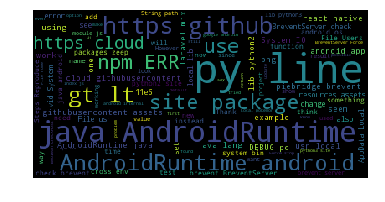

In [38]:
wordcloud = WordCloud().generate(" ".join(issue_comments_opened_description))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

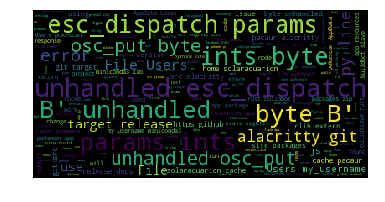

In [60]:
wordcloud = WordCloud().generate(" ".join(issue_comments_closed_description))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [91]:
issue_comments_2.head(100)

,action,title,description,exact_date_opened,comment
0,closed,Plaid-like animation for search (in icons/wall...,,2016-02-02 01:54:34,Plaid-like animation for search (in icons/wall...
1,closed,Replace PkRequestManager,Probably by creating a custom implementation s...,2016-02-12 19:31:06,Replace PkRequestManagerProbably by creating a...
2,closed,Select all/none option in the Requests page is...,Probably with the fixes for the title not chan...,2016-02-01 01:57:00,Select all/none option in the Requests page is...
3,closed,Transparent nav bar inset sometimes isn't set ...,,2016-02-01 01:57:21,Transparent nav bar inset sometimes isn't set ...
4,closed,"Icon request ""backend""",https://plus.google.com/111080505870850761155/...,2016-03-25 14:35:43,"Icon request ""backend""https://plus.google.com/..."
5,opened,Toolbar title sometimes gets cut off with elli...,"Happens randomly, restarting the app always so...",2016-02-01 01:57:44,Toolbar title sometimes gets cut off with elli...
6,opened,Homepage FAB sometimes doesn't have correct in...,The home FAB sometimes goes under the nav bar....,2016-02-01 01:58:17,Homepage FAB sometimes doesn't have correct in...
7,opened,about section,"bottom card hides behind navbar, can't tap any...",2016-02-01 02:11:08,"about sectionbottom card hides behind navbar, ..."
8,opened,Severe landscape issues,![screenshot_20160131-201610](https://cloud.gi...,2016-02-01 02:18:07,Severe landscape issues![screenshot_20160131-2...
9,opened,"Tapping a wallpaper to load it full-size, resu...",![2016-02-01 11 12 33](https://cloud.githubuse...,2016-02-01 11:14:34,"Tapping a wallpaper to load it full-size, resu..."
